This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Tensorflow basics</div>

This notebook contains a gentle introduction to the [low-level API of Tensorflow](https://www.tensorflow.org/programmers_guide/low_level_intro) (built with Tensorflow 1.8).

Nice list of extra resources on [Aymeric Damien's github](https://github.com/aymericdamien/TensorFlow-Examples).

1. [A plain regression problem](#sec1)
2. [Introducing minibatches](#sec2)
3. [What if

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
# Imports
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

/home/emmanuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. A plain regression problem

We want to train a neural network to learn the square root function over the $[0,10]$ interval.

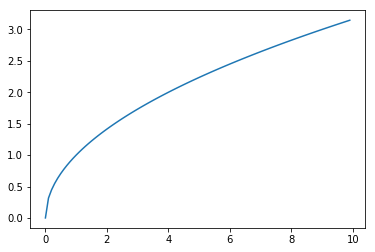

In [3]:
x_data = np.arange(0,10,0.1).reshape((100,1))
y_data = np.sqrt(x_data)
plt.plot(x_data,y_data);

Start a TF session (we could actually do that after defining the graph).

In [4]:
sess = tf.Session()

Define the neural network. 2 hidden layers with 20 units each, ReLU activation functions.

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 1])
y_true = tf.placeholder(tf.float32, shape=[None, 1])
hidden_layer1 = tf.layers.dense(x, units=20, activation=tf.nn.relu)
hidden_layer2 = tf.layers.dense(hidden_layer1, units=20, activation=tf.nn.relu)
y_pred = tf.layers.dense(hidden_layer2, units=1)

Initialize layers' weights (warning, only initializes variables that exist when the global_variables_initializer() function is called).

In [6]:
init = tf.global_variables_initializer()
sess.run(init)

Make a first prediction.

In [7]:
sess.run(y_pred, feed_dict={x: x_data[0:10]})

array([[ 0.        ],
       [-0.01943095],
       [-0.03886191],
       [-0.05829287],
       [-0.07772382],
       [-0.09715478],
       [-0.11658573],
       [-0.13601667],
       [-0.15544763],
       [-0.1748786 ]], dtype=float32)

Define the loss function.

In [8]:
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred) # Fill the options
print(loss)

Tensor("mean_squared_error/value:0", shape=(), dtype=float32)


Define optimizer.

In [9]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)

Train network for 10000 epochs.

In [10]:
nb_epochs = 10000
losses = np.zeros((nb_epochs))

for i in range(nb_epochs):
    _, loss_value = sess.run((train, loss), feed_dict={x: x_data, y_true: y_data})
    losses[i] = loss_value


Plot loss evolution and final learned function.

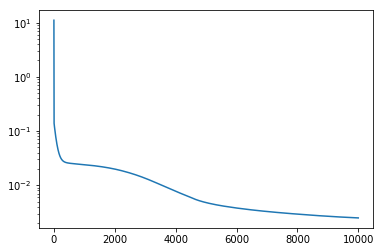

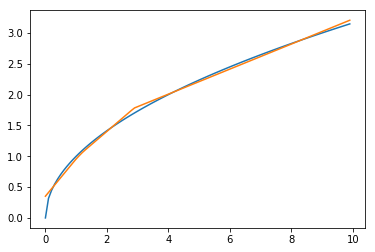

In [11]:
plt.semilogy(losses)

new_pred = sess.run(y_pred, feed_dict={x: x_data})
plt.figure()

plt.plot(x_data, y_data)
plt.plot(x_data, new_pred);

# <a id="sec2"></a> 2. Introducing minibatches

Let's train a softmax linear regression on the MNIST data.

In [12]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 20
batch_size = 100
display_step = 1

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Network definition.

In [13]:
# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

Define loss function and optimizer.

In [14]:
# Minimize cross-entropy
loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

Define generalization performance.

In [15]:
# Generalization accuracy
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Train

In [16]:
# Start training
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = np.zeros(training_epochs)
accuracies = np.zeros(training_epochs)

# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        _, l = sess.run([optimizer, loss], feed_dict={x: batch_xs, y: batch_ys})

        # Compute average loss
        losses[epoch] += l / total_batch
    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        print ("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(losses[epoch]))
    
    # Test accuracy on the first 3000 test samples
    accuracies[epoch] = accuracy.eval({x: mnist.test.images[:3000], y: mnist.test.labels[:3000]}, session=sess)

print ("Optimization Finished!")

Epoch: 0001 loss= 1.183996798
Epoch: 0002 loss= 0.665269951
Epoch: 0003 loss= 0.552805211
Epoch: 0004 loss= 0.498728625
Epoch: 0005 loss= 0.465448679
Epoch: 0006 loss= 0.442563378
Epoch: 0007 loss= 0.425537221
Epoch: 0008 loss= 0.412142971
Epoch: 0009 loss= 0.401443253
Epoch: 0010 loss= 0.392400603
Epoch: 0011 loss= 0.384818277
Epoch: 0012 loss= 0.378182104
Epoch: 0013 loss= 0.372391051
Epoch: 0014 loss= 0.367301291
Epoch: 0015 loss= 0.362746748
Epoch: 0016 loss= 0.358611132
Epoch: 0017 loss= 0.354816575
Epoch: 0018 loss= 0.351450954
Epoch: 0019 loss= 0.348292139
Epoch: 0020 loss= 0.345457987
Optimization Finished!


Test the model.

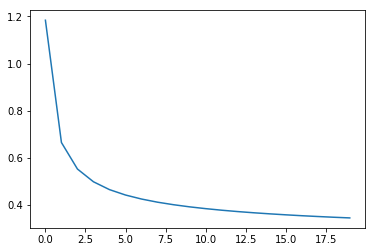

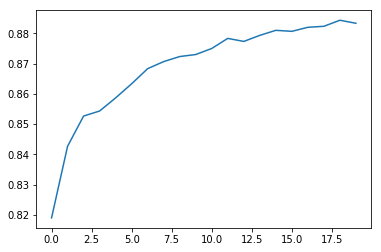

In [17]:
plt.plot(range(training_epochs),losses)
plt.figure()
plt.plot(range(training_epochs),accuracies)

# <a id="sec3. What if I want to define the gradients myself?

In some cases, you'll want to define the weight updates (gradients) yourself, rather than relying on the automated differenciation of a loss function.

Why? Because sometimes the loss function is not easily defined by you still have a parameter update rule.

As a toy example, let's take the previous example and define the gradient ourselves. But since we're lazy and this is just a toy example, we'll use the `tf.gradients` function to define these gradients.

It all begins exactly the same way as previously.

In [18]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 100
display_step = 1

# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 100
display_step = 1

# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now comes the part where we don't want to define a loss function but rather provide gradients. Here we cheat by still defining `loss` but we will just use it as an intermediate variable to call `tf.gradients`. 

In [19]:
loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
grad_W, grad_b = tf.gradients(xs=[W, b], ys=loss)

Note that we could have avoided cheating by writing the derivation of `loss` with respect to all elements in `W` and `b` by hand and obtaining:

`grad_W =  - tf.matmul ( tf.transpose(x) , y - pred) 
grad_b = - tf.reduce_mean( tf.matmul(tf.transpose(x), y - pred), reduction_indices=0)`

But we're lazy...

We still want to use Tensorflow's `GradientDescentOptimizer` to perform the update operation.

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
update_weights = optimizer.apply_gradients(zip((grad_W, grad_b),(W,b)))

Generalization scores.

In [21]:
# Generalization accuracy
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Let's train.

In [22]:
# Start training
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = np.zeros(training_epochs)
accuracies = np.zeros(training_epochs)

# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        _, l = sess.run([update_weights, loss], feed_dict={x: batch_xs, y: batch_ys})

        # Compute average loss
        losses[epoch] += l / total_batch
    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        print ("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(losses[epoch]))
    
    # Test accuracy on the first 3000 test samples
    accuracies[epoch] = accuracy.eval({x: mnist.test.images[:3000], y: mnist.test.labels[:3000]}, session=sess)

print ("Optimization Finished!")

Epoch: 0001 loss= 1.183845381
Epoch: 0002 loss= 0.665338269
Epoch: 0003 loss= 0.552888911
Epoch: 0004 loss= 0.498732261
Epoch: 0005 loss= 0.465545731
Epoch: 0006 loss= 0.442576799
Epoch: 0007 loss= 0.425562178
Epoch: 0008 loss= 0.412138210
Epoch: 0009 loss= 0.401412783
Epoch: 0010 loss= 0.392411556
Optimization Finished!


Test the model.

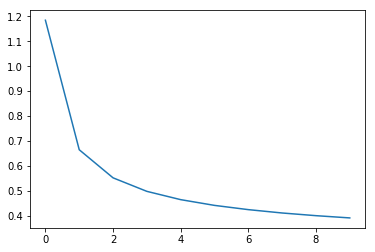

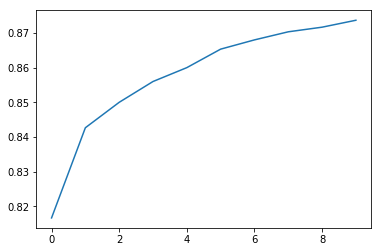

In [23]:
plt.plot(range(training_epochs),losses)
plt.figure()
plt.plot(range(training_epochs),accuracies)

Note that it's also possible to totally get rid of the `GradientDescentOptimizer` by defining the operations ourself. We can define the two following tensors:

`update_W = W.assign(W - learning_rate * grad_W)
update_b = b.assign(b - learning_rate * grad_b)`

And replace the `_, l = sess.run([update_weights, loss], feed_dict={x: batch_xs, y: batch_ys})` line above by:

`_, _, l = sess.run([update_W, update_b, loss], feed_dict={x: batch_xs, y: batch_ys})`